# BentoML Example: fashion-mnist with Keras

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. 

This notebook demonstrates how to use BentoML to turn a Keras model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=keras&ea=keras-fashion-mnist&dt=keras-fashion-mnist)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install bentoml
!pip install tensorflow numpy matplotlib

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version: %s" % tf.__version__)

import bentoml
print("BentoML Version: %s" % bentoml.__version__)

Tensorflow Version: 1.13.1
BentoML Version: 0.4.1


## Load Fashion MNIST dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

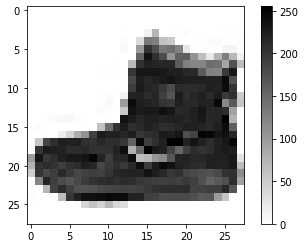

In [5]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We should scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

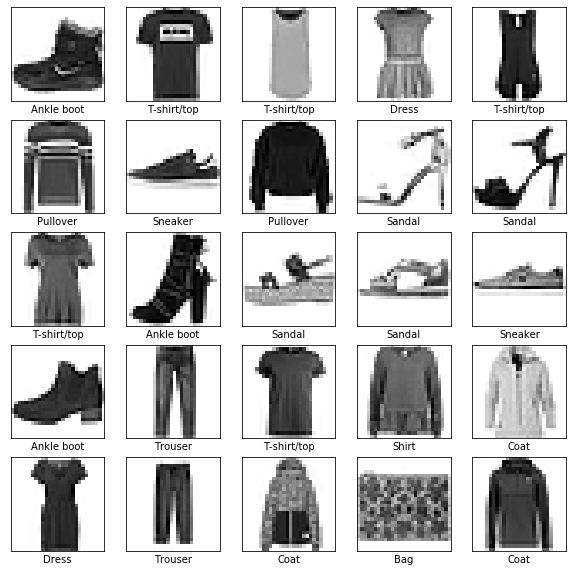

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [8]:
# Reshaping the images so that our model can accept it
train_images  = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

## Build the model

In [9]:
model = keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)  

## Compile the model

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [11]:
model.fit(train_images, train_labels, batch_size=64, epochs=1)

60000/60000 [==============================] - 54s 898us/sample - loss: 0.5839 - acc: 0.7876


## Evaluate model accuracy

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 3s 310us/sample - loss: 0.3808 - acc: 0.8632
Test accuracy: 0.8632


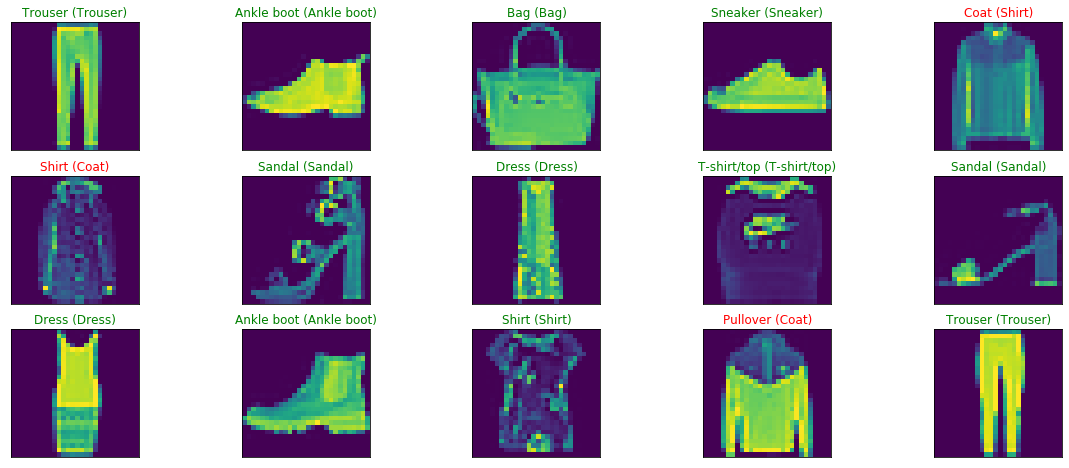

In [13]:
y_hat = model.predict_classes(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = y_hat[index]
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Predict on a single image

Let's first see the test image and and its label:

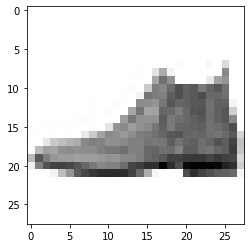

Class: Ankle boot


In [14]:
plt.imshow(test_images[0].squeeze(-1), cmap=plt.cm.binary)
plt.show()
print('Class:', class_names[test_labels[0]])

In [15]:
pred_idx = model.predict_classes(np.expand_dims(test_images[0], 0))[0]
print('Prediction:', class_names[pred_idx])

Prediction: Ankle boot


## Define BentoService for model serving

In [16]:
%%writefile keras_fashion_mnist.py

import numpy as np
from PIL import Image
from bentoml import api, artifacts, env, BentoService
from bentoml.artifact import KerasModelArtifact
from bentoml.handlers import ImageHandler

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@env(pip_dependencies=['tensorflow==1.13.1', 'Pillow', 'numpy'])
@artifacts([KerasModelArtifact('classifier')])
class KerasFashionMnistService(BentoService):
        
    @api(ImageHandler, pilmode='L')
    def predict(self, img):
        img = Image.fromarray(img).resize((28, 28))
        img = np.array(img.getdata()).reshape((1,28,28,1))
        class_idx = self.artifacts.classifier.predict_classes(img)[0]
        return class_names[class_idx]

Overwriting keras_fashion_mnist.py


## Save BentoService to file archive

In [17]:
# 1) import the custom BentoService defined above
from keras_fashion_mnist import KerasFashionMnistService

# 2) `pack` it with required artifacts
mnist_svc = KerasFashionMnistService.pack(classifier=model)

# 3) save your BentoSerivce to file archive
saved_path = mnist_svc.save()

[2019-09-17 15:56:01,746] INFO - Successfully saved Bento 'KerasFashionMnistService:2019_09_17_6bf40ee7' to path: /Users/chaoyuyang/bentoml/repository/KerasFashionMnistService/2019_09_17_6bf40ee7


## Load BentoService from archive


In [19]:
svc = bentoml.load(saved_path)

svc.predict(test_images[0].squeeze(-1))

[2019-09-17 15:56:03,996] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.


'Ankle boot'

# "pip install" a BentoService archive

BentoML user can directly pip install saved BentoML archive with `pip install $SAVED_PATH`,  and use it as a regular python package.

In [20]:
!pip install {saved_path}

Processing /Users/chaoyuyang/bentoml/repository/KerasFashionMnistService/2019_09_17_6bf40ee7
  Stored in directory: /private/var/folders/ns/vc9qhmqx5dx_9fws7d869lqh0000gn/T/pip-ephem-wheel-cache-so0ithe7/wheels/f1/a4/19/b3cc5f661c8dc58d49fdbad2f140edefcb4e81f5fb258f781b
Successfully built KerasFashionMnistService
  Found existing installation: KerasFashionMnistService 2019-07-25-1cbfb31a
    Uninstalling KerasFashionMnistService-2019-07-25-1cbfb31a:
      Successfully uninstalled KerasFashionMnistService-2019-07-25-1cbfb31a


In [21]:
# Your bentoML model class name will become packaged name
import KerasFashionMnistService

ms = KerasFashionMnistService.load()
ms.predict(test_images[0].squeeze(-1))

[2019-09-17 15:56:11,486] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.
[2019-09-17 15:56:11,701] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.


'Ankle boot'

the installed pip package also comes with a CLI tool:

In [22]:
!KerasFashionMnistService predict --input=sample_image.png

2019-09-17 15:56:18.283695: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Ankle boot


# Model Serving via REST API

In your termnial, run the following command to start the REST API server:

In [23]:
!bentoml serve {saved_path}

2019-09-17 15:56:28.177722: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
 * Serving Flask app "KerasFashionMnistService" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Sep/2019 15:56:30] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2019 15:56:32] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2019 15:56:42] "POST /predict HTTP/1.1" 200 -
^C


Test sending request to API Server from terminal:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

or:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

## Containerize REST API server with Docker

** _Make sure you have `docker` installed, note that it is not available when running in Google Colaboratory_

In [25]:
!cd {saved_path} && docker build -t keras-fashion-mnist .

Sending build context to Docker daemon  5.015MB
Step 1/11 : FROM continuumio/miniconda3
 ---> ae46c364060f
Step 2/11 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Using cache
 ---> 2f135ada8e2d
Step 3/11 : EXPOSE 5000
 ---> Using cache
 ---> 738f652d09ae
Step 4/11 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 70c62a45013a
Step 5/11 : RUN conda update conda -y       && conda install pip numpy scipy       && pip install gunicorn six
 ---> Using cache
 ---> fe5d966ecc35
Step 6/11 : COPY . /bento
 ---> 117cc481fab5
Step 7/11 : WORKDIR /bento
 ---> Running in a1205aac29f3
Removing intermediate container a1205aac29f3
 ---> f56e5ba83c2e
Step 8/11 : RUN conda env update -n base -f /bento/environment.yml
 ---> Running in f9ed0194cacb
Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The followin

Removing intermediate container f9ed0194cacb
 ---> a88c7898f76f
Step 9/11 : RUN pip install -r /bento/requirements.txt
 ---> Running in 077860b42643
ERROR: Exception:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pip/_vendor/urllib3/contrib/pyopenssl.py", line 304, in recv_into
    return self.connection.recv_into(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/OpenSSL/SSL.py", line 1814, in recv_into
    self._raise_ssl_error(self._ssl, result)
  File "/opt/conda/lib/python3.7/site-packages/OpenSSL/SSL.py", line 1614, in _raise_ssl_error
    raise WantReadError()
OpenSSL.SSL.WantReadError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pip/_vendor/urllib3/response.py", line 397, in _error_catcher
    yield
  File "/opt/conda/lib/python3.7/site-packages/pip/_vendor/urllib3/response.py", line 479, in read
    data = self._fp.read(amt

In [ ]:
!docker run -p 5000:5000 keras-fashion-mnist

2019-09-17 23:22:34.619671: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-17 23:22:34.649071: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2904000000 Hz
2019-09-17 23:22:34.650896: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x557443431590 executing computations on platform Host. Devices:
2019-09-17 23:22:34.651003: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[2019-09-17 23:22:37 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2019-09-17 23:22:37 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2019-09-17 23:22:37 +0000] [1] [INFO] Using worker: sync
[2019-09-17 23:22:37 +0000] [62] [INFO